# Principal Component Analysis of Spotify artists

Let's run it on the huge 2500 x 2500 matrix and map each artist to a 2d point!

In [24]:
# ~21 sec
import json
from utils import name2id, id2name, artist_data, top_artists
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 150

In [3]:
artist_names = [id2name[_id] for _id in top_artists]

In [4]:
# ~11 sec
with open("./data/2.5k_matrix.json") as fin:
    big_matrix = json.load(fin)

In [ ]:
N = 2500
corr_matrix = np.zeros((N, N), dtype=int)

for i in tqdm(range(N)):
    scores = big_matrix[top_artists[i]]

    for j in range(N):
        other_id = top_artists[j]
        if not other_id in scores: continue
        corr_matrix[i, j] = np.log(scores[other_id])

## Scale features so that mean=0, std=1 for columns and rows

In [6]:
def scale_columns(mat):
    return StandardScaler().fit_transform(mat)

def scale_rows(mat):
    return StandardScaler().fit_transform(mat.T).T

corr_matrix_scaled = scale_columns(scale_rows(corr_matrix))

In [11]:
PCA_2d = PCA(n_components=2)
artist_2d = PCA_2d.fit_transform(corr_matrix_scaled)
print(artist_2d.shape)

(2500, 2)


In [18]:
# Save this
with open("./data/2.5k_pca_log.json", "w") as fout:
    fout.write("{\n")
    for i in range(N):
        fout.write(f"  \"{top_artists[i]}\": {list(artist_2d[i])}")
        if i < N - 1: fout.write(",")
        fout.write("\n")
    fout.write("}\n")

## Un-overlap points

In [118]:
with open("./data/2.5k_pca_log.json") as fin:
    points_dict = json.load(fin)

raw_pca_points = np.array(list(points_dict.values()))

In [129]:
def plot(p, r=0.3):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_xlim([min(p[:,0]) - r, max(p[:,1]) + r])
    ax.set_ylim([min(p[:,1]) - r, max(p[:,1]) + r])

    # https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
    circle_patches = [plt.Circle(center, r) for center in p]
    for cp in circle_patches:
        ax.add_patch(cp)

In [81]:
raw_points = (np.random.rand(10, 2) - 0.5) * 2
print(raw_points)

[[ 0.32006237  0.20296755]
 [ 0.93940075  0.94093731]
 [ 0.11998604  0.53872836]
 [-0.00980274 -0.5752243 ]
 [-0.93526597  0.75035921]
 [ 0.59183552 -0.07404751]
 [ 0.47628446  0.49173528]
 [-0.52994188  0.74515875]
 [-0.79815215 -0.152572  ]
 [-0.80372274  0.14336764]]


In [133]:
# Un-overlap code
def dist(a, b):
    """Squared distance between a and b"""
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def unoverlap(a, b, r):
    d = dist(a, b)
    if d >= 2 * r - 1e-3: return False, a, b
    mtd = (2*r - d) / 2
    u = (b - a) / d
    return True, a - u * mtd, b + u * mtd

def unoverlap_all(raw_points):    
    points = np.copy(raw_points)
    n = len(points)

    iters = 0
    while True:
        count = 0
        for i in tqdm(range(n)):
            for j in range(i + 1, n):
                moved, a, b = unoverlap(points[i], points[j], 0.3)
                if moved:
                    count += 1
                    points[i], points[j] = a, b        
        
        print(f"Iter {str(iters).rjust(6)}, moved {str(count).rjust(5)}/{n * (n + 1) // 2}")
        iters += 1
        
        if count == 0: return points

100%|██████████| 10/10 [00:00<00:00, 141699.46it/s]


Iter      0, moved     8/55


100%|██████████| 10/10 [00:00<00:00, 5046.69it/s]


Iter      1, moved     9/55


100%|██████████| 10/10 [00:00<00:00, 4854.52it/s]


Iter      2, moved     9/55


100%|██████████| 10/10 [00:00<00:00, 10034.22it/s]


Iter      3, moved     7/55


100%|██████████| 10/10 [00:00<00:00, 8933.55it/s]


Iter      4, moved     6/55


100%|██████████| 10/10 [00:00<00:00, 10126.28it/s]


Iter      5, moved     4/55


100%|██████████| 10/10 [00:00<00:00, 10067.94it/s]


Iter      6, moved     4/55


100%|██████████| 10/10 [00:00<?, ?it/s]


Iter      7, moved     2/55


100%|██████████| 10/10 [00:00<?, ?it/s]


Iter      8, moved     0/55


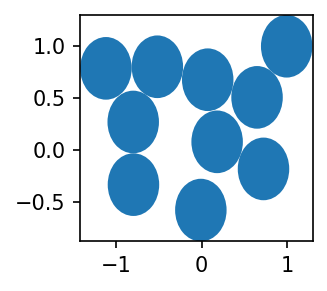

In [134]:
plot(unoverlap_all(raw_points))

## Try it on the actual thing

In [135]:
points = unoverlap_all(raw_pca_points)

100%|██████████| 2500/2500 [00:12<00:00, 205.16it/s]


Iter      0, moved   759/3126250


100%|██████████| 2500/2500 [00:13<00:00, 187.40it/s] 


Iter      1, moved   395/3126250


100%|██████████| 2500/2500 [00:12<00:00, 201.78it/s] 


Iter      2, moved   341/3126250


100%|██████████| 2500/2500 [00:11<00:00, 219.56it/s]


Iter      3, moved   282/3126250


100%|██████████| 2500/2500 [00:13<00:00, 185.67it/s]


Iter      4, moved   218/3126250


100%|██████████| 2500/2500 [00:12<00:00, 203.51it/s]


Iter      5, moved   154/3126250


100%|██████████| 2500/2500 [00:13<00:00, 180.64it/s]


Iter      6, moved    99/3126250


100%|██████████| 2500/2500 [00:16<00:00, 155.01it/s]


Iter      7, moved    75/3126250


100%|██████████| 2500/2500 [00:12<00:00, 192.74it/s]


Iter      8, moved    52/3126250


100%|██████████| 2500/2500 [00:13<00:00, 187.32it/s]


Iter      9, moved    39/3126250


100%|██████████| 2500/2500 [00:22<00:00, 112.40it/s]


Iter     10, moved    20/3126250


100%|██████████| 2500/2500 [00:22<00:00, 110.86it/s]


Iter     11, moved    17/3126250


100%|██████████| 2500/2500 [00:24<00:00, 101.42it/s]


Iter     12, moved    11/3126250


100%|██████████| 2500/2500 [00:20<00:00, 124.03it/s]


Iter     13, moved     5/3126250


100%|██████████| 2500/2500 [00:14<00:00, 171.65it/s]


Iter     14, moved     1/3126250


100%|██████████| 2500/2500 [00:17<00:00, 144.34it/s]

Iter     15, moved     0/3126250


In [137]:
with open("./data/2.5k_pca_log_adjusted.json", "w") as fout:
    fout.write("{\n")
    for i in range(N):
        fout.write(f"  \"{top_artists[i]}\": {list(points[i])}")
        if i < N - 1: fout.write(",")
        fout.write("\n")
    fout.write("}\n")